In [1]:
#!pip install requirements.txt

In [2]:
#!bash load_data.sh

Здесь воспроизведен подход из статьи QaNER: Prompting Question Answering Models for Few-shot Named Entity Recognition, 2022: https://arxiv.org/abs/2203.01543 . Код написан на основе кода из репозитория https://github.com/dayyass/QaNER/ . 

In [3]:
import os, sys

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'ner'))

In [5]:
import torch

In [6]:
USE_GPU = torch.cuda.is_available()

In [7]:
USE_GPU = False

In [8]:
PATH_TO_TRAIN = './conll2003/train.txt'
PATH_TO_TEST = './conll2003/test.txt'
PATH_TO_VALID = './conll2003/valid.txt'

In [9]:
from ner.data_utils import load_qa_sentences

In [10]:
train_sentences, train_spans = load_qa_sentences(PATH_TO_TRAIN)
test_sentences, test_spans = load_qa_sentences(PATH_TO_TEST)
valid_sentences, valid_spans = load_qa_sentences(PATH_TO_VALID)

In [11]:
from ner.data_utils import create_mapping, iter_over_tags

tag_to_id, id_to_tag = create_mapping(train_sentences, iter_over_tags, False)

In [12]:
from ner.datasets.qa_dataset import QADataset

In [13]:
PROMPT_MAPPER = {
    "LOC": "location",
    "PER": "person",
    "ORG": "organization",
    "MISC": "miscellaneous entity"
}

Для обучения QA модели мы преобразуем исходные данные типа предложение = (слово, метка) в данные типа вопрос - ответ по опредленному паттерну. Таким образом список вопросов представляет собой конструкцию типа "What is location?".

In [14]:
train_dataset = QADataset(train_sentences, train_spans, PROMPT_MAPPER)
test_dataset = QADataset(test_sentences, test_spans, PROMPT_MAPPER)
valid_dataset = QADataset(valid_sentences, valid_spans, PROMPT_MAPPER)

In [15]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

In [16]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [17]:
tokenizer_kwargs = {
        "max_length": 512,
        "truncation": "only_second",
        "padding": True,
        "return_tensors": "pt",
        "return_offsets_mapping": True,
    }

In [18]:
tokenizer_call = lambda questions, contexts: tokenizer(questions, contexts, **tokenizer_kwargs)

In [19]:
from ner.datasets.qa_dataset import create_qa_loader

In [20]:
train_dataloader = create_qa_loader(train_dataset, tokenizer=tokenizer_call, shuffle=True)
test_dataloader = create_qa_loader(test_dataset, tokenizer=tokenizer_call, shuffle=True)
valid_dataloader = create_qa_loader(valid_dataset, tokenizer=tokenizer_call, shuffle=True)

In [21]:
model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased')

NOTE: Redirects are currently not supported in Windows or MacOs.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were

In [22]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-5,
)

In [23]:
from ner.qa_trainer import train_qa

Такое волатильное поведение лосса можно попрбовать сгладить заменой параметров оптимизатора и увеличением размера батча, но в силу того, что целью было решить задачу NER и проверить работоспобность подхода в приципе, а также за неимением достаточного количества вычислительных ресуросов для экспериментов, мною было решено остановиться на текущей версии.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over train batches:   0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


batch loss / train 1.2621707916259766 99
batch loss / train 0.9330219030380249 199
batch loss / train 0.7166524529457092 299
batch loss / train 0.7091749906539917 399
batch loss / train 0.6100441217422485 499
batch loss / train 0.5537805557250977 599
batch loss / train 0.6633173227310181 699
batch loss / train 0.3849353790283203 799
batch loss / train 0.3908948600292206 899
batch loss / train 0.6009188294410706 999


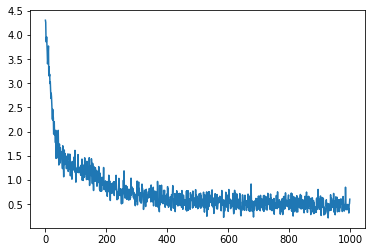

batch loss / train 0.39492207765579224 1099
batch loss / train 0.23927243053913116 1199
batch loss / train 0.4958091378211975 1299
batch loss / train 0.3695806860923767 1399
batch loss / train 0.5848621726036072 1499


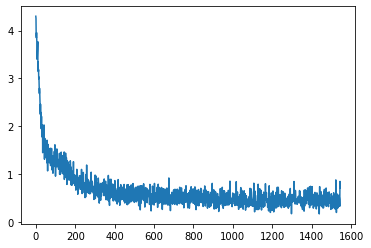

              precision    recall  f1-score   support

         LOC       0.98      0.74      0.85      8297
        MISC       0.96      0.63      0.76      4593
           O       0.82      0.99      0.90     43163
         ORG       0.96      0.72      0.82     10025
         PER       0.99      0.76      0.86     11128

    accuracy                           0.87     77206
   macro avg       0.94      0.77      0.84     77206
weighted avg       0.89      0.87      0.87     77206



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over test batches:   0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.99      0.84      0.91      2094
        MISC       0.98      0.77      0.86      1268
           O       0.85      0.99      0.92      9758
         ORG       0.97      0.81      0.88      2092
         PER       1.00      0.79      0.88      3149

    accuracy                           0.90     18361
   macro avg       0.96      0.84      0.89     18361
weighted avg       0.92      0.90      0.90     18361



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over train batches:   0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


batch loss / train 0.5356874465942383 1644
batch loss / train 0.46313315629959106 1744
batch loss / train 0.31808507442474365 1844
batch loss / train 0.31799769401550293 1944
batch loss / train 0.3991997241973877 2044
batch loss / train 0.36240285634994507 2144
batch loss / train 0.2693330645561218 2244
batch loss / train 0.5116569995880127 2344
batch loss / train 0.5052052140235901 2444
batch loss / train 0.6552699208259583 2544


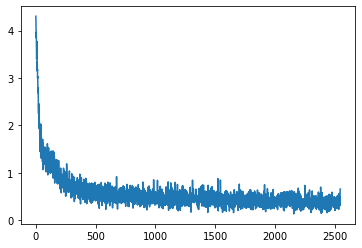

batch loss / train 0.4450318515300751 2644
batch loss / train 0.377440869808197 2744
batch loss / train 0.28667593002319336 2844
batch loss / train 0.27959850430488586 2944
batch loss / train 0.3558691442012787 3044


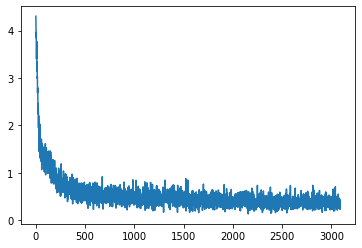

              precision    recall  f1-score   support

         LOC       0.99      0.84      0.91      8297
        MISC       0.99      0.87      0.92      4593
           O       0.89      0.99      0.94     43163
         ORG       0.98      0.85      0.91     10025
         PER       1.00      0.82      0.90     11128

    accuracy                           0.93     77206
   macro avg       0.97      0.87      0.92     77206
weighted avg       0.93      0.93      0.93     77206



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over test batches:   0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.98      0.82      0.89      2094
        MISC       0.97      0.82      0.89      1268
           O       0.85      0.99      0.91      9758
         ORG       0.97      0.80      0.88      2092
         PER       0.99      0.77      0.87      3149

    accuracy                           0.90     18361
   macro avg       0.95      0.84      0.89     18361
weighted avg       0.91      0.90      0.90     18361



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over train batches:   0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


batch loss / train 0.265623539686203 3189
batch loss / train 0.2927229702472687 3289
batch loss / train 0.40913113951683044 3389
batch loss / train 0.6166931986808777 3489
batch loss / train 0.3068601191043854 3589
batch loss / train 0.3653867542743683 3689
batch loss / train 0.5339089632034302 3789
batch loss / train 0.3464163541793823 3889
batch loss / train 0.3333500325679779 3989
batch loss / train 0.3923383355140686 4089


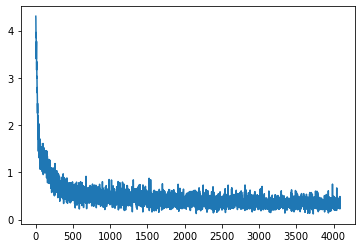

batch loss / train 0.2706110179424286 4189
batch loss / train 0.3856331706047058 4289
batch loss / train 0.3744964003562927 4389
batch loss / train 0.38347965478897095 4489
batch loss / train 0.33245331048965454 4589


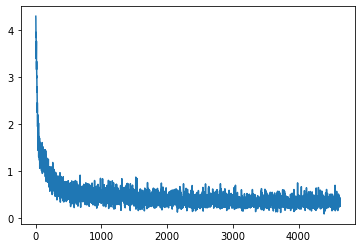

              precision    recall  f1-score   support

         LOC       1.00      0.84      0.91      8297
        MISC       0.99      0.88      0.93      4593
           O       0.89      1.00      0.94     43163
         ORG       0.99      0.87      0.93     10025
         PER       1.00      0.83      0.91     11128

    accuracy                           0.93     77206
   macro avg       0.98      0.88      0.92     77206
weighted avg       0.94      0.93      0.93     77206



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over test batches:   0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.99      0.85      0.91      2094
        MISC       0.98      0.84      0.90      1268
           O       0.88      0.99      0.93      9758
         ORG       0.98      0.87      0.92      2092
         PER       0.99      0.82      0.90      3149

    accuracy                           0.92     18361
   macro avg       0.96      0.87      0.91     18361
weighted avg       0.93      0.92      0.92     18361



In [36]:
train_qa(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    valid_dataloader,
    id_to_tag=None,
    number_of_epochs= 3,
    gradient_clip=5.0,
    use_gpu=USE_GPU
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


loop over test batches:   0%|          | 0/376 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.95      0.84      0.90      1925
        MISC       0.91      0.80      0.85       918
           O       0.90      0.98      0.93     10653
         ORG       0.97      0.86      0.91      2496
         PER       0.99      0.86      0.92      2773

    accuracy                           0.92     18765
   macro avg       0.94      0.87      0.90     18765
weighted avg       0.93      0.92      0.92     18765

